In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import seaborn as sns

/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [6]:
images = '../Project/Original Images'

img_width, img_height = 224, 224  # Default input size for VGG16

batch_size=12

In [3]:
# Instantiate convolutional base

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

In [7]:
train_generator = datagen.flow_from_directory(images,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

Found 304 images belonging to 3 classes.


In [8]:
validation_generator = datagen.flow_from_directory(images,
                                                         target_size=(img_height, img_width),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 76 images belonging to 3 classes.


In [9]:
# Extract features from the train generator using VGG16
train_features = np.zeros(shape=(304, 7, 7, 512))
train_labels = np.zeros(shape=(304, 3))

# Pass through pre-trained convolution base
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = conv_base.predict(inputs_batch)
    train_features[i * batch_size: (i+1) * batch_size] = features_batch
    train_labels[i * batch_size: (i+1) * batch_size] = labels_batch
    i += 1
    if i*batch_size >= 304:
        break

In [10]:
print(train_features.shape)
print(train_labels.shape)

(304, 7, 7, 512)
(304, 3)


In [11]:
# Extract features from validation generator using VGG16
val_features = np.zeros(shape=(76, 7, 7, 512))
val_labels = np.zeros(shape=(76, 3))

# Pass through pre-trained convolution base
i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = conv_base.predict(inputs_batch)
    val_features[i * batch_size: (i+1) * batch_size] = features_batch
    val_labels[i * batch_size: (i+1) * batch_size] = labels_batch
    i += 1
    if i*batch_size >= 76:
        break

In [12]:
print(val_features.shape)
print(val_labels.shape)

(76, 7, 7, 512)
(76, 3)


In [13]:
#Flattening the features extraction to train the DT as it expects array of <= 2 dimensions
train_features_flatten = train_features.reshape((train_features.shape[0], 7 * 7 * 512))
val_features_flatten = val_features.reshape((val_features.shape[0], 7 * 7 * 512))

In [16]:
#Initializing GridSearchCV for DT to find the optimum value of max leaf nodes

dt = DecisionTreeClassifier(random_state=42)
dt_GS = GridSearchCV(dt, param_grid={"max_leaf_nodes":[10,20,30,50,70,90,100,110,115]}, cv=5)

In [17]:
dt_GS.fit(train_features_flatten, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [10, 20, 30, 50, 70, 90, 100, 110,
  

In [18]:
results = pd.DataFrame(dt_GS.cv_results_)

In [19]:
print("Best parameters of Grid Search 1: ", dt_GS.best_params_,'\n\n')
print(results[['param_max_leaf_nodes','mean_test_score','rank_test_score']])

Best parameters of Grid Search 1:  {'max_leaf_nodes': 20} 


  param_max_leaf_nodes  mean_test_score  rank_test_score
0                   10         0.832459                9
1                   20         0.835792                1
2                   30         0.835792                1
3                   50         0.835792                1
4                   70         0.835792                1
5                   90         0.835792                1
6                  100         0.835792                1
7                  110         0.835792                1
8                  115         0.835792                1


In [20]:
max_leaf_nodes=([10,20,30,50,70,90,100,110,115])

In [21]:
acc_score_train = []
acc_score_val = []

In [22]:
for item in max_leaf_nodes:
    dt_prune = DecisionTreeClassifier(max_leaf_nodes = item, random_state = 42)
    dt_prune.fit(train_features_flatten, train_labels)
    train_labels_pred_prune = dt_prune.predict(train_features_flatten)
    acc_score_train.append(accuracy_score(train_labels, train_labels_pred_prune))
    val_labels_pred_prune = dt_prune.predict(val_features_flatten)
    acc_score_val.append(accuracy_score(val_labels, val_labels_pred_prune))
print(acc_score_train,'\n',acc_score_val)

[0.9736842105263158, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
 [0.7894736842105263, 0.8157894736842105, 0.8157894736842105, 0.8157894736842105, 0.8157894736842105, 0.8157894736842105, 0.8157894736842105, 0.8157894736842105, 0.8157894736842105]


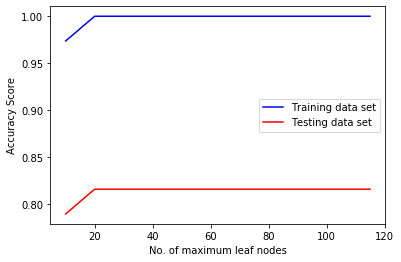

In [23]:
plt.plot(max_leaf_nodes,acc_score_train,'b-',max_leaf_nodes,acc_score_val,'r-')
plt.xlabel('No. of maximum leaf nodes')
plt.ylabel('Accuracy Score')
plt.legend(("Training data set","Testing data set",))
plt.show()

In [24]:
#Using GridSearchCV's best results to predict training dataset i.e. max leaf nodes = 20
train_labels_pred_GS = dt_GS.predict(train_features_flatten)
val_labels_pred_GS = dt_GS.predict(val_features_flatten)



Accuracy on Training Data:  1.0


Classification Matrix on Training Data:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00       112

   micro avg       1.00      1.00      1.00       304
   macro avg       1.00      1.00      1.00       304
weighted avg       1.00      1.00      1.00       304
 samples avg       1.00      1.00      1.00       304



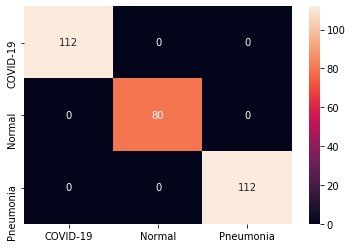

In [36]:
#Accuracy Score, Classification Report & Confusion Matrix on training data

print("\n\nAccuracy on Training Data: ", accuracy_score(train_labels, train_labels_pred_GS))

print("\n\nClassification Matrix on Training Data:\n\n",classification_report(train_labels, train_labels_pred_GS))

categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(train_labels.argmax(axis=1), train_labels_pred_GS.argmax(axis=1))
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')



Accuracy on Testing Data:  0.8157894736842105


Classification Matrix on Testing Data:

               precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.75      0.90      0.82        20
           2       0.88      0.75      0.81        28

   micro avg       0.82      0.82      0.82        76
   macro avg       0.82      0.82      0.82        76
weighted avg       0.82      0.82      0.82        76
 samples avg       0.82      0.82      0.82        76



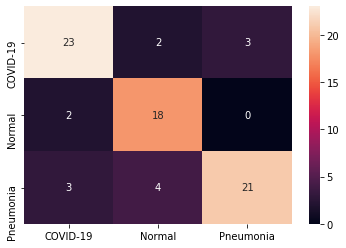

In [37]:
#Accuracy Score, Classification Report & Confusion Matrix on training data

print("\n\nAccuracy on Testing Data: ", accuracy_score(val_labels, val_labels_pred_GS))

print("\n\nClassification Matrix on Testing Data:\n\n",classification_report(val_labels, val_labels_pred_GS))

categories = ['COVID-19','Normal','Pneumonia']
cm1 = confusion_matrix(val_labels.argmax(axis=1), val_labels_pred_GS.argmax(axis=1))
sns.heatmap(cm1, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')